# Generating Images to Fool an MNIST Classifier

A classic introductory deep learning exercise is to train a neural network like the [LeNet-5](https://en.wikipedia.org/wiki/LeNet) to classify the MNIST dataset of handwritten digits. Similarly, from a Quality-Diversity (QD) standpoint, it is a simple exercise to generate images that fool such networks. As shown in [Nguyen 2015](http://anhnguyen.me/project/fooling/), one can use simple MAP-Elites to find images that make the network believe with high accuracy that it sees certain digits, even though the images look like random noise to humans. In this tutorial, we replicate some of the results of Nguyen 2015 using the pyribs version of MAP-Elites.

## Setup

In [ ]:
%pip install ribs torch torchvision

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision

from ribs.archives import GridArchive
from ribs.emitters import GaussianEmitter
from ribs.optimizers import Optimizer

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Preliminary: MNIST Network

For our ~victim~ classifier network, we train a LeNet-5 to classify MNIST. If you are not familiar with PyTorch, we recommend referring to the [PyTorch 60-minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html). On the other hand, if you are familiar, feel free to skip to the next section, where we demonstrate how to fool the network.

First, we load and preprocess the MNIST dataset.

In [4]:
# Transform each image by turning it into a tensor and then
# normalizing the values.
MEAN_TRANSFORM = 0.1307
STD_DEV_TRANSFORM = 0.3081
mnist_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((MEAN_TRANSFORM,), (STD_DEV_TRANSFORM,))
])

TRAIN_BATCH_SIZE = 64
TRAINLOADER = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               train=True,
                               download=True,
                               transform=mnist_transforms),
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)

TEST_BATCH_SIZE = 1000
TESTLOADER = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               train=False,
                               transform=mnist_transforms),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

This is our training function. We use negative log likelihood loss and Adam optimization.

In [5]:
def fit(net, epochs):
    """Trains net for the given number of epochs."""
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        print(f"=== Epoch {epoch + 1} ===")
        total_loss = 0.0

        # Iterate through batches in the shuffled training dataset.
        for batch_i, data in enumerate(TRAINLOADER):
            inputs = data[0].to(device)
            labels = data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            if (batch_i + 1) % 100 == 0:
                print(f"Batch {batch_i + 1:5d}: {total_loss}")
                total_loss = 0.0

Now, we define the LeNet-5 and train it for 2 epochs. We have annotated the shapes of the images (excluding the batch dimension) as they pass through the network.

In [6]:
LENET5 = nn.Sequential(
    nn.Conv2d(1, 6, (5, 5), stride=1, padding=0),  # (1,28,28) -> (6,24,24)
    nn.MaxPool2d(2),  # (6,24,24) -> (6,12,12)
    nn.ReLU(),
    nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),  # (6,12,12) -> (16,8,8)
    nn.MaxPool2d(2),  # (16,8,8) -> (16,4,4)
    nn.ReLU(),
    nn.Flatten(),  # (16,4,4) -> (256,)
    nn.Linear(256, 120),  # (256,) -> (120,)
    nn.ReLU(),
    nn.Linear(120, 84),  # (120,) -> (84,)
    nn.ReLU(),
    nn.Linear(84, 10),  # (84,) -> (10,)
    nn.LogSoftmax(dim=1),  # (10,) log probabilities
).to(device)

fit(LENET5, 2)

=== Epoch 1 ===
Batch   100: 102.51357261836529
Batch   200: 32.9656745493412
Batch   300: 21.529952958226204
Batch   400: 15.667681757360697
Batch   500: 15.097078140825033
Batch   600: 13.270927803590894
Batch   700: 12.564910806715488
Batch   800: 9.672732993029058
Batch   900: 9.525600061751902
=== Epoch 2 ===
Batch   100: 8.397011974360794
Batch   200: 7.109771997667849
Batch   300: 8.579339948482811
Batch   400: 7.7545816991478205
Batch   500: 6.249599913135171
Batch   600: 8.113473088946193
Batch   700: 7.2713636280968785
Batch   800: 7.562341179233044
Batch   900: 6.3597436924465


To see how well the network does, we'll evaluate it on the train and test sets.

In [7]:
def evaluate(net, loader):
    """Evaluates the network's accuracy on the images in the dataloader."""
    correct_per_num = [0 for _ in range(10)]
    total_per_num = [0 for _ in range(10)]

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.to("cpu"), 1)
            c = (predicted == labels).squeeze()
            for i in range(len(c)):
                label = labels[i]
                correct_per_num[label] += c[i].item()
                total_per_num[label] += 1

    for i in range(10):
        print(f"Class {i}: {correct_per_num[i] / total_per_num[i]:5.3f}"
              f" ({correct_per_num[i]} / {total_per_num[i]})")
    print(f"TOTAL    : {sum(correct_per_num) / sum(total_per_num):5.3f}"
          f" ({sum(correct_per_num)} / {sum(total_per_num)})")

In [8]:
evaluate(LENET5, TRAINLOADER)

Class 0: 0.994 (5889 / 5923)
Class 1: 0.995 (6708 / 6742)
Class 2: 0.985 (5871 / 5958)
Class 3: 0.940 (5762 / 6131)
Class 4: 0.992 (5798 / 5842)
Class 5: 0.972 (5269 / 5421)
Class 6: 0.986 (5835 / 5918)
Class 7: 0.994 (6225 / 6265)
Class 8: 0.958 (5604 / 5851)
Class 9: 0.938 (5583 / 5949)
TOTAL    : 0.976 (58544 / 60000)


In [9]:
evaluate(LENET5, TESTLOADER)

Class 0: 0.992 (972 / 980)
Class 1: 0.997 (1132 / 1135)
Class 2: 0.986 (1018 / 1032)
Class 3: 0.954 (964 / 1010)
Class 4: 0.996 (978 / 982)
Class 5: 0.979 (873 / 892)
Class 6: 0.975 (934 / 958)
Class 7: 0.992 (1020 / 1028)
Class 8: 0.966 (941 / 974)
Class 9: 0.942 (950 / 1009)
TOTAL    : 0.978 (9782 / 10000)


## Fooling the Classifier with Random Noise

Above, we trained a reasonably high-performing classifier. In order to fool the classifier into seeing various digits, we use MAP-Elites. As we have 10 distinct digits (0-9), we have a discrete behavior space with 10 values. Above, our classifier outputs a log probability vector with its belief that it is seeing each digit. Thus, our objective for each digit is to maximize the probability that the classifier assigns to the image associated with it. For instance, for digit 5, we want to generate an image that makes the classifier believe with high probability that is seeing a 5.

In pyribs, we implement MAP-Elites with a `GridArchive` and a `GaussianEmitter`. Below, we start by constructing the `GridArchive`. The archive has 10 bins and a range of (0,10). Since `GridArchive` was originally designed for continuous spaces, it does not directly support discrete spaces, but by using these settings, we have a bin for digits 0-9.

In [10]:
archive = GridArchive([10], [(0, 10)])

Second, the `GaussianEmitter` begins at an image filled with 0.5 (i.e. grey, since pixels are in the range (0,1)) and generates random images by adding Gaussian noise with standard deviation 0.5. After the first iteration, the emitter adds the Gaussian noise to random elites in the archive.

In [11]:
img_size = (28, 28)
flat_img_size = 784  # 28 * 28
emitters = [
    GaussianEmitter(
        archive,
        # Start with a grey image.
        np.full(flat_img_size, 0.5),
        # 0.5 to cover the whole range.
        0.5,
        # Bound the generated images to the pixel range of the images.
        bounds=[(0, 1)] * flat_img_size,
        batch_size=64,
    )
]

Finally, we construct the optimizer to connect the archive and emitters together.

In [12]:
optimizer = Optimizer(archive, emitters)

With the components created, we now generate the images. As the emitter had batch size 64 and we run 15,000 iterations, we evaluate 960,000 images in total.

In [13]:
total_itrs = 15_000
start_time = time.time()

for itr in range(1, total_itrs + 1):
    sols = optimizer.ask()

    with torch.no_grad():

        # Reshape and normalize the image and pass it through the network.
        imgs = sols.reshape((-1, 1, *img_size))
        imgs = (imgs - MEAN_TRANSFORM) / STD_DEV_TRANSFORM
        imgs = torch.tensor(imgs, dtype=torch.float32, device=device)
        output = LENET5(imgs)

        # The BC is the digit that the network believes it is seeing, i.e. the
        # digit with the maximum probability. The objective is the actual
        # probability associated with that digit.
        scores, predicted = torch.max(output.to("cpu"), 1)
        scores = torch.exp(scores)
        objs = scores.numpy()
        bcs = predicted.numpy()

    optimizer.tell(objs, bcs)

    if itr % 1000 == 0:
        print(f"Iteration {itr} complete after {time.time() - start_time} s")

Iteration 1000 complete after 6.405324459075928 s
Iteration 2000 complete after 11.881330728530884 s
Iteration 3000 complete after 17.29666304588318 s
Iteration 4000 complete after 22.742225170135498 s
Iteration 5000 complete after 28.1128511428833 s
Iteration 6000 complete after 33.4985466003418 s
Iteration 7000 complete after 38.969311237335205 s
Iteration 8000 complete after 44.38250923156738 s
Iteration 9000 complete after 49.784961462020874 s
Iteration 10000 complete after 55.21747589111328 s
Iteration 11000 complete after 60.6211154460907 s
Iteration 12000 complete after 66.14762783050537 s
Iteration 13000 complete after 71.53709769248962 s
Iteration 14000 complete after 76.90295338630676 s
Iteration 15000 complete after 82.26457858085632 s


Below, we display the results we found with MAP-Elites. The `index_0` column shows the digit that each image corresponds to the `objective` column shows the network's belief that the image is that digit. The `solution` columns show the image's pixels.

In [14]:
archive.as_pandas().sort_values("index_0")

,index_0,behavior_0,objective,solution_0,solution_1,solution_2,solution_3,solution_4,solution_5,solution_6,...,solution_774,solution_775,solution_776,solution_777,solution_778,solution_779,solution_780,solution_781,solution_782,solution_783
2,0,0.0,0.987680,1.000000,1.000000,0.011156,0.169332,1.000000,0.701903,0.217690,...,0.714737,0.708943,0.000000,0.753090,0.734133,0.000000,1.000000,0.477669,0.000000,0.396209
0,1,1.0,0.999146,1.000000,0.614113,0.107083,0.431910,0.093555,0.312382,0.000000,...,0.000000,0.187751,1.000000,0.764512,0.000000,1.000000,1.000000,0.477747,0.426100,0.913944
6,2,2.0,0.981022,0.954979,0.549241,0.000000,0.000000,0.643126,0.569946,0.664567,...,0.000000,0.878428,0.539377,0.104789,1.000000,0.000000,0.287717,0.583123,0.877207,0.202896
8,3,3.0,0.903618,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.468883,...,0.325218,0.939044,0.000000,1.000000,0.000000,0.923697,0.000000,0.798279,1.000000,0.000000
1,4,4.0,0.999301,0.000000,1.000000,0.482723,0.000000,0.180477,0.000000,0.538591,...,0.574619,0.835598,0.365552,0.993877,0.625835,1.000000,1.000000,0.573823,0.988071,1.000000
5,5,5.0,0.970175,0.953075,0.000000,0.116254,1.000000,0.000000,0.675124,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.500610,1.000000,1.000000,0.000000,0.000000,0.616909
9,6,6.0,0.862747,0.500315,1.000000,0.893130,1.000000,0.410955,0.311204,0.679928,...,0.000000,0.252908,0.000000,0.956751,0.847560,0.808687,0.533426,1.000000,0.147118,0.000000
4,7,7.0,0.992296,0.512495,0.827997,1.000000,0.739287,0.000000,0.664664,0.000000,...,0.043437,1.000000,0.141383,0.170574,0.215346,0.445491,0.327223,0.311870,0.848086,1.000000
3,8,8.0,0.998332,0.000000,1.000000,0.579672,0.000000,0.741452,0.000000,0.243033,...,0.185573,0.766609,0.715961,0.000000,1.000000,0.000000,0.074394,0.249930,1.000000,1.000000
7,9,9.0,0.839247,0.876791,0.000000,0.655479,1.000000,0.587206,0.599552,1.000000,...,1.000000,0.000000,1.000000,0.835658,0.000000,0.337262,0.794993,1.000000,0.100611,0.769564


Here, we display the images found by the network. Interestingly, though the images look mostly like noise, we can occasionally make out traces of the original digit.

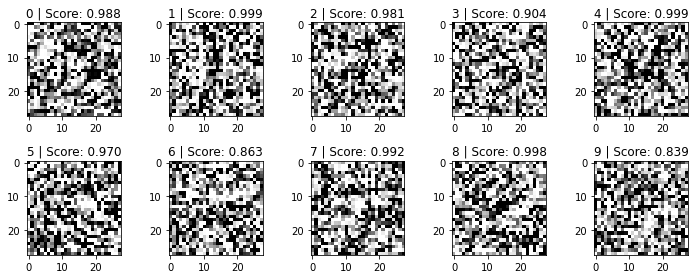

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
fig.tight_layout()
ax = ax.flatten()
found = set()

# Display images.
for _, row in archive.as_pandas().iterrows():
    i = int(row.loc["index_0"])
    found.add(i)
    obj = row.loc["objective"]
    ax[i].set_title(f"{i} | Score: {obj:.3f}")
    img = row.loc["solution_0":].to_numpy().reshape(28, 28)

    # No need to normalize image because we want to see the original.
    ax[i].imshow(img, cmap="Greys")

# Mark digits that we did not generate images for.
for i in range(10):
    if i not in found:
        ax[i].set_title(f"{i} | (no solution)")

## Conclusion

In this tutorial, we used MAP-Elites to generate images that fool a LeNet-5 MNIST classifier. For further exploration, we recommend referring to [Nguyen 2015](http://anhnguyen.me/project/fooling/) and attmepting to replicate or extend the other experiments described in the paper.